# Importação dos pacotes

---



In [401]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import cv2
from google.colab.patches import cv2_imshow

In [2]:
def plot_digits(X, target):

  n = X.shape[0]
  f, ax = plt.subplots(1, n)

  for i in range(0 , n):
    x = X[i].reshape(28, 28)

    ax[i].imshow(x, cmap="binary")
    ax[i].set_title('target: ' + target[i])
    ax[i].axis("off")

# Carregando os dados

---



In [409]:
mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [410]:
X, y = mnist.data, mnist.target

exemplos das instâncias disponíveis na base de dados:

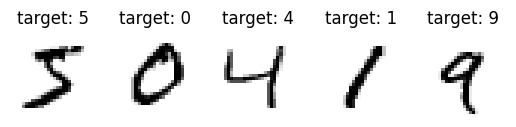

In [5]:
plot_digits(X[0:5], y[0:5])

# Separando os conjutos de Treino e Teste

---



In [212]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Treinando um modelo Random Forest

---



In [370]:
from sklearn.metrics import classification_report

In [7]:
forest_clf = RandomForestClassifier(random_state=42)
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)

avaliando o desempenho do modelo:

In [389]:
target_names = sorted(list(set(mnist.target)))
print(classification_report(y_train, y_train_pred, target_names = target_names))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5923
           1       0.98      0.98      0.98      6742
           2       0.95      0.96      0.96      5958
           3       0.96      0.95      0.95      6131
           4       0.96      0.97      0.96      5842
           5       0.96      0.96      0.96      5421
           6       0.97      0.98      0.98      5918
           7       0.97      0.96      0.97      6265
           8       0.95      0.94      0.95      5851
           9       0.95      0.95      0.95      5949

    accuracy                           0.96     60000
   macro avg       0.96      0.96      0.96     60000
weighted avg       0.96      0.96      0.96     60000



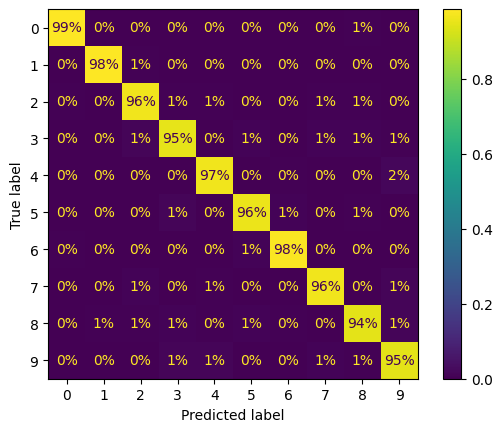

In [398]:
#ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")

# Detecctando furos na imagens

---



## Função `findCircles`
Retorna a quantidade de círculos (furos) na imagem e a imagem com a região do furo destacada (`plot = True`)



In [355]:
def findCircles(x, plot = True):

  img = x.reshape(28, 28).astype('uint8')
  img_hull = None
  qnt = 0 # quantidade de furos

  img_resized = cv2.resize(img, (img.shape[1]*3, img.shape[0]*3), interpolation=cv2.INTER_LANCZOS4)
  sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  img_sharpen = cv2.filter2D(img_resized, -1, sharpen_kernel)
  img_thresh = cv2.threshold(img_sharpen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(4, 4))
  img_dilate = cv2.dilate(img_thresh, kernel, iterations = 1)
  #cv2_imshow(img_dilate)

  img_erode = cv2.erode(img_dilate, kernel, iterations = 1)
  #cv2_imshow(img_erode)

  contours, hierarchy = cv2.findContours(img_erode , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

  img_copy = img_erode.copy()
  img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

  for cnt, hrc  in zip(contours, hierarchy[0]):

    #approx = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
    hasParent = hrc[3] != -1 # verdadeiro se o contorno está contido em outro

    if hasParent:
      qnt += 1
      hull = cv2.convexHull(cnt)

      x, y, w, h = cv2.boundingRect(cnt)
      cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 1)

      img_hull = cv2.drawContours(img_copy, [hull], 0, [0, 0, 255])
      img_hull = cv2.cvtColor(img_hull, cv2.COLOR_BGR2RGB)

  if plot is False:
    return qnt
  elif img_hull is not None:
    return [qnt, img_hull]
  else:
    return [qnt, img_copy]

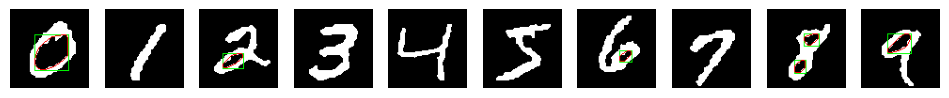

In [356]:
f, ax = plt.subplots(1, 10, figsize=(12, 12))
for i in range(0, 10):
  idx = list(y_train).index(str(i))
  ax[i].imshow(findCircles(X_train[idx], True)[1])
  ax[i].axis("off")

adicionando a nova variável ao modelo

In [391]:
num_furos = np.array([findCircles(xi, False) for xi in X_train])
num_furos = num_furos.reshape(len(num_furos), 1)

In [392]:
X_train_aug = np.append(X_train, num_furos, axis=1)
y_train_aug_pred = cross_val_predict(forest_clf, X_train_aug, y_train, cv=3)

In [393]:
print(classification_report(y_train, y_train_aug_pred, target_names = target_names))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5923
           1       0.99      0.98      0.98      6742
           2       0.96      0.97      0.96      5958
           3       0.97      0.95      0.96      6131
           4       0.97      0.97      0.97      5842
           5       0.97      0.96      0.96      5421
           6       0.97      0.98      0.98      5918
           7       0.97      0.97      0.97      6265
           8       0.96      0.96      0.96      5851
           9       0.96      0.95      0.95      5949

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



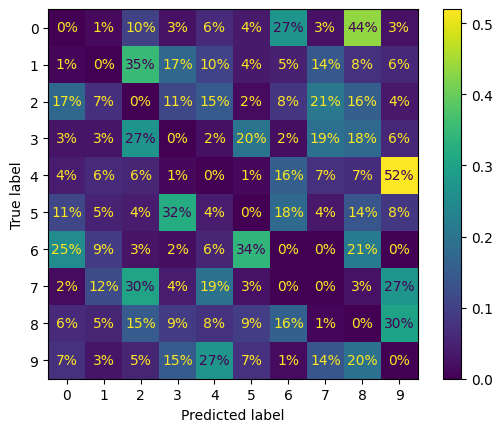

In [400]:
sample_weight = (y_train_aug_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_aug_pred, sample_weight = sample_weight, normalize="true", values_format=".0%")
#ConfusionMatrixDisplay.from_predictions(y_train, y_train_aug_pred)

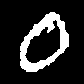

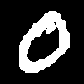

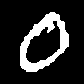

In [126]:
img = X[1].reshape(28, 28).astype('uint8')

img_resized = cv2.resize(img, (img.shape[1]*3, img.shape[0]*3), interpolation=cv2.INTER_LANCZOS4)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img_sharpen = cv2.filter2D(img_resized, -1, sharpen_kernel)
img_thresh = cv2.threshold(img_sharpen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

cv2_imshow(img_thresh)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))
img_dilate = cv2.dilate(img_thresh, kernel, iterations = 1)
cv2_imshow(img_dilate)

img_erode = cv2.erode(img_dilate, kernel, iterations = 1)
cv2_imshow(img_erode)

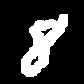

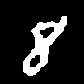

Area: 115.5
Edges: 6
Hierarchy: [ 2 -1 -1  0]


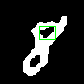

Hull Edges: 11
Convexo?: True


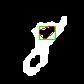

Area: 104.5
Edges: 6
Hierarchy: [-1  1 -1  0]


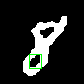

Hull Edges: 10
Convexo?: True


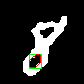

In [262]:
img = X_train[17].reshape(28, 28).astype('uint8')

img_resized = cv2.resize(img, (img.shape[1]*3, img.shape[0]*3), interpolation=cv2.INTER_LANCZOS4)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img_sharpen = cv2.filter2D(img_resized, -1, sharpen_kernel)
img_thresh = cv2.threshold(img_sharpen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#img_edges = cv2.Canny(img_thresh, 100, 200)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(4, 4))
img_dilate = cv2.dilate(img_thresh, kernel, iterations = 1)
cv2_imshow(img_dilate)

img_erode = cv2.erode(img_dilate, kernel, iterations = 1)
cv2_imshow(img_erode)

contours, hierarchy = cv2.findContours(img_erode , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

for cnt, hrc  in zip(contours, hierarchy[0]):

  approx = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
  hasParent = hrc[3] != -1 # verdadeiro se o contorno está contido em outro

  #if cv2.isContourConvex(approx) or True:
  if hasParent:


    print('Area: ' + str(cv2.contourArea(cnt)))
    print('Edges: ' + str(len(approx)))
    print('Hierarchy: ' + str(hrc))

    img_copy = img_erode.copy()
    x, y, w, h = cv2.boundingRect(cnt)
    #img_resized = cv2.resize(img_thresh, (img_thresh.shape[1]*3, img_thresh.shape[0]*3), interpolation=cv2.INTER_LANCZOS4)
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2_imshow(img_copy)

    hull = cv2.convexHull(cnt)

    print('Hull Edges: ' + str(len(hull)))
    print('Convexo?: ' + str(cv2.isContourConvex(hull)))

    # Drawing the contours for debugging purposes.
    img_hull = cv2.drawContours(img_copy, [hull], 0, [0, 0, 255])
    cv2_imshow(img_hull)
